# Sobre este Notebook

En este Notebook vamos a mostrar distintas técnicas que pueden servir de cara a la práctica 3:

- Uso de datos no balanceados.
- Etiquetar de forma correcta.

# Trabajando con datos no Balanceados

Lo primero vamos a mostrar cómo se pueden trabajar con datos no balanceados. Para ello, usaremos un paquete específico para ello: [imbalanced-learn](http://glemaitre.github.io/imbalanced-learn/install.html).

Una explicación más detallada puede verse en https://towardsdatascience.com/how-to-deal-with-imbalanced-data-in-python-f9b71aba53eb


¿Por qué es malo *aprender* con datos no balanceados?

Por varios motivos:
    
- Si una clase está *sobrerepresentada* frente al resto, el modelo tendrá mucha tendencia a elegirlo. Esto puede ser problemático o no, si los datos finales a predecir mantienen el mismo no-balanceamiento, pero si no fuese el caso sí podría dar problemas.

- Si una clase aparece poco en las muestras respecto al resto el modelo puede tener tendencia a *despreciar* dicha clase ya que le afecta poco a sus medidas, llegando incluso a ignorarla en casos extremos. Esto se produce independientemente de si dicho no-balanceamiento aparece también en los datos finales sobre los que se vaya a predecir.

Como comento, la gravedad depende del nivel de desbalanceamiento y de si el conjunto de datos a predecir mantiene el balanceamiento o no, pero en cualquier caso puede ser problemático, y es recomendable tratarlo.

Pero antes de empezar, hay que valorar los datos que tenemos en el Datasets y el grado de balanceo. Dependendiendo de las características puede ser más conveniente uno que otro: undersampling, y oversampling.

Ambas técnicas están implementadas en un paquete específico que usaremos: [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) que está [bien documentado](http://glemaitre.github.io/imbalanced-learn/index.html)

## Creando datos sintáticos

Para este ejemplo no vamos a usar datos reales, si no datos sintéticos, Scikit-learn posee varios métodos para ello.

In [1]:
from imblearn.datasets import make_imbalance
from sklearn.datasets import make_moons

In [2]:
X, y = make_moons(n_samples=2000, shuffle=True, noise=0.5, random_state=10)
# Le metemos 
X, y = make_imbalance(X, y,  sampling_strategy={0: 100, 1: 600}, min_c_=1)

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

Lo primero es ver cómo de desbalanceado está

In [4]:
from collections import Counter

In [5]:
Counter(y)

Counter({0: 100, 1: 600})

Se ve que está desbalanceado, una clase aparece siete veces más que otra.

##  Visualmente

In [6]:
def plot(X, y, title="Ejemplo de clases"):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.8)
    ax.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5)

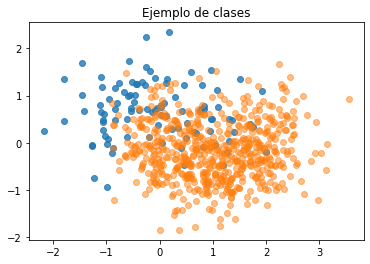

In [7]:
plot(X, y)

De unas hay mucho más clases que de otras.

## Undersampling

El undersampling es muy fácil, implica filtrar las instancias de clases que ya tengan muchos representantes. Hay varias estrategias, pero ahora aplicamos el modo por defecto:

[Documentación de la librería de undersampling](https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html)

Escogemos uno aleatorio primero

In [8]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss

Es interesante el atributo **sampling_strategy**, especialmente para multiclase.

In [9]:
# rus = RandomUnderSampler(random_state=0, sampling_strategy='majority')
rus = NearMiss(version=1)

In [10]:
Xu, yu = rus.fit_resample(X, y)

In [11]:
Counter(yu)

Counter({0: 100, 1: 100})

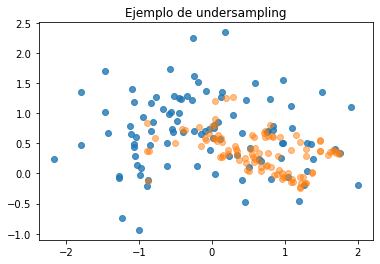

In [12]:
plot(Xu, yu, title="Ejemplo de undersampling")

## Oversampling

Ahora vamos a probar con  undersampling (SMOTE)

In [13]:
from imblearn.over_sampling import SMOTE

In [14]:
Xo, yo = SMOTE().fit_resample(X, y)

In [15]:
Counter(yo)

Counter({0: 600, 1: 600})

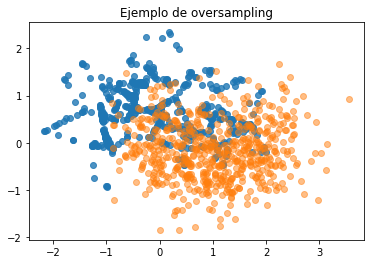

In [16]:
plot(Xo, yo, title="Ejemplo de oversampling")

# Aplicando misma Etiqueta a varios ficheros

Hay que tener cuidado aplicando etiquetas a ficheros distintos

In [17]:
import pandas as pd

Como sólo quiero mostrar el problema de etiquetado ignoro los nulos

In [18]:
df_train = pd.read_csv("train.csv").dropna()

In [19]:
df_test = pd.read_csv("test.csv").dropna()

Vamos a etiquetar un atributo cualquiera, como Asientos

In [20]:
df_train.Asientos.head()

14    5.0
31    5.0
32    7.0
39    5.0
42    5.0
Name: Asientos, dtype: float64

In [21]:
df_test.Asientos.head()

8     5.0
15    7.0
26    5.0
42    5.0
52    5.0
Name: Asientos, dtype: float64

## Forma errónea de hacerlo

In [22]:
from sklearn.preprocessing import LabelEncoder

In [23]:
df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

Aplicamos el etiquetado de forma independiente a cada uno

In [24]:
df_train.Asientos = LabelEncoder().fit_transform(df_train_orig.Asientos)

In [25]:
df_test.Asientos = LabelEncoder().fit_transform(df_test_orig.Asientos)

In [26]:
df_train.Asientos.head()

14    2
31    2
32    4
39    2
42    2
Name: Asientos, dtype: int64

In [27]:
df_test.Asientos.head()

8     2
15    3
26    2
42    2
52    2
Name: Asientos, dtype: int64

In [28]:
for asientos in df_train_orig.Asientos.unique():
    label_train = df_train.Asientos[df_train_orig.Asientos == asientos].unique()
    label_test = df_test.Asientos[df_test_orig.Asientos == asientos].unique()
    
    
    if len(label_train)==0 or len(label_test)==0:
        continue
    
    if label_train != label_test:
        print("Error, {} es etiquetado en train como {} y en test como {}".format(asientos, label_train[0], label_test[0]))
        break

Error, 7.0 es etiquetado en train como 4 y en test como 3


Ese problema puede hacer que las predicciones sobre el de test sean mucho peores.

## Forma correcta de hacerlo

La solución sería aprender a partir del fichero del mismo nombre con todos los datos

Primero aprendemos las etiquetas a partir de todos

In [29]:
labelAsientos = LabelEncoder().fit(pd.read_csv("asientos.csv").Asientos)

Ahora usamos el mismo labelAsientos a ambos

In [30]:
df_train.Asientos = labelAsientos.transform(df_train_orig.Asientos)
df_test.Asientos = labelAsientos.transform(df_test_orig.Asientos)

In [31]:
df_train.Asientos.head()

14    3
31    3
32    5
39    3
42    3
Name: Asientos, dtype: int64

In [32]:
df_test.Asientos.head()

8     3
15    5
26    3
42    3
52    3
Name: Asientos, dtype: int64

Ahora si comprobamos de nuevo

In [33]:
correcto = True

for asientos in df_train_orig.Asientos.unique():
    label_train = df_train.Asientos[df_train_orig.Asientos == asientos].unique()
    label_test = df_test.Asientos[df_test_orig.Asientos == asientos].unique()
    
    if len(label_train)==0 or len(label_test)==0:
        continue
    
    if label_train != label_test:
        print("Error, {} es etiquetado en train como {} y en test como {}".format(asientos, label_train, label_test))
        correcto = False
        break
        
if correcto:
    print("Todo perfecto")

Todo perfecto


Vemos que ahora las etiquetas coinciden.

## Generando el fichero para Kaggle

Si tenemos un modelo ya aprendido de entrenamiento, con el preprocesado deseado, lo que se pide es:

In [34]:
# Si tenemos model ya aprendido
# model = ....
data_test = pd.read_csv("test.csv")
# Preprocesamos data_test
# Eliminamos el campo id ya que no se debe usar para predecir
ids = data_test['id']
del data_test['id']
# Ahora predecimos
predict = model.predict(data_test)
# Generamos 
df_result = pd.DataFrame({'id': ids, 'Precio_cat': predict})
df_result.to_csv("mis_resultados.csv", index=False)

NameError: name 'model' is not defined

**Nota:** El código anterior es un borrador, no es seguro que funcione ya que no lo he podido probar por no tener el model creado.